In [ ]:
import os
import cv2
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

classes = {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}

def load_images(path):
    X = []
    Y = []
    for cls in classes:
        class_path = os.path.join(path, cls)
        img_names = os.listdir(class_path)
        for img_name in img_names:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Ensure images are read in color
            if img is not None:
                X.append(cv2.resize(img, (224, 224)))  # Resize to 224x224
                Y.append(classes[cls])
    return np.array(X), np.array(Y)

train_path = 'Dataset/train/'
X, Y = load_images(train_path)

unique, counts = np.unique(Y, return_counts=True)
print("Number of images per class before balancing:")
print(dict(zip(unique, counts)))

Y = Y.astype(int)

# Flatten images for sampling
X_flat = X.reshape(X.shape[0], -1)

# Define oversampling and undersampling strategies
oversampler = RandomOverSampler(sampling_strategy={0: 1500, 1: 1500})
undersampler = RandomUnderSampler(sampling_strategy={2: 1500, 3: 1500})

# Apply oversampling
X_oversampled, Y_oversampled = oversampler.fit_resample(X_flat, Y)

# Apply undersampling
X_resampled, Y_resampled = undersampler.fit_resample(X_oversampled, Y_oversampled)

# Reshape X_resampled back to (n_samples, 224, 224, 3)
num_samples = X_resampled.shape[0]
image_height, image_width, channels = 224, 224, 3
X_resampled = X_resampled.reshape(num_samples, image_height, image_width, channels)

# Print class distributions after balancing
unique, counts = np.unique(Y_resampled, return_counts=True)
print("Number of images per class after balancing:")
print(dict(zip(unique, counts)))

def convert_to_green_fire_blue(img):
    return cv2.applyColorMap(img, cv2.COLORMAP_JET)

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def preprocess_data(X):
    X_preprocessed = []
    for img in X:
        img_colored = convert_to_green_fire_blue(img)
        img_clahe = apply_clahe(img_colored)
        X_preprocessed.append(img_clahe)
    return np.array(X_preprocessed)

X_resampled = preprocess_data(X_resampled)

X_train, X_val, Y_train, Y_val = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42)

unique_train, counts_train = np.unique(Y_train, return_counts=True)
unique_val, counts_val = np.unique(Y_val, return_counts=True)

print("Number of images per class in training data:")
print(dict(zip(unique_train, counts_train)))
print("Number of images per class in validation data:")
print(dict(zip(unique_val, counts_val)))

def create_mobilenetv2_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = create_mobilenetv2_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model_mobilenetv2.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Define the train and validation generators
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32, shuffle=True)
valid_generator = valid_datagen.flow(X_val, Y_val, batch_size=32, shuffle=False)

# Create TensorFlow datasets from the generators
train_dataset = tf.data.Dataset.from_generator(lambda: train_generator,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 224, 224, 3], [None]))
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_generator,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 224, 224, 3], [None]))
valid_dataset = valid_dataset.repeat()

steps_per_epoch = len(train_generator)
validation_steps = len(valid_generator)

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=valid_dataset,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping]
)

Number of images per class before balancing:
{0: 896, 1: 64, 2: 3200, 3: 2240}
Number of images per class after balancing:
{0: 1500, 1: 1500, 2: 1500, 3: 1500}
Number of images per class in training data:
{0: 1170, 1: 1217, 2: 1211, 3: 1202}
Number of images per class in validation data:
{0: 330, 1: 283, 2: 289, 3: 298}
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.4109 - loss: 1.4983 - val_accuracy: 0.6092 - val_loss: 0.8843
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.6415 - loss: 0.8326 - val_accuracy: 0.6700 - val_loss: 0.7669
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6769 - loss: 0.7402 - val_accuracy: 0.6542 - val_loss: 0.7971
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.7011 - loss: 0.6879 - val_accuracy: 0.7192 - val_loss: 0.6433
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.7476 - loss: 0.5883 - val_accuracy: 0.7142 - val_loss: 0.6421
Epoch 6/50
150/150 ━━━━━━━━━━━━━━

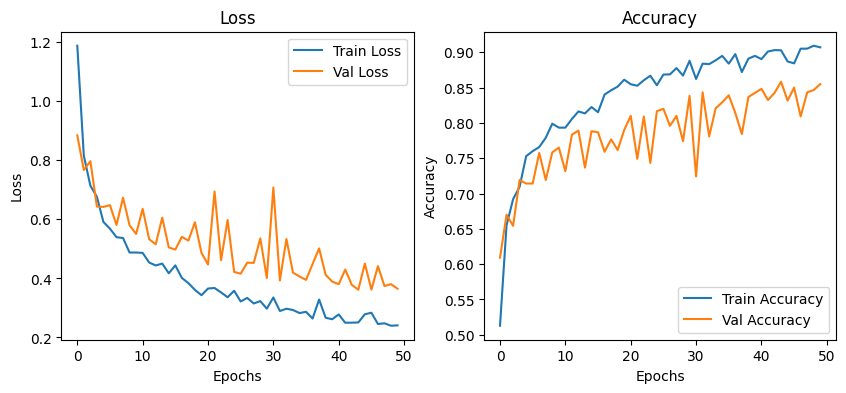

Number of images per class in test data before balancing:
{0: 179, 1: 12, 2: 640, 3: 448}
Number of images per class in test data after balancing:
{0: 320, 1: 320, 2: 320, 3: 319}
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 773ms/step - accuracy: 0.8802 - loss: 0.3341
Test Accuracy: 0.85
Test Loss: 0.38
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 762ms/step
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.81      0.76      0.78       320
ModerateDemented       0.90      0.90      0.90       320
     NonDemented       0.68      0.81      0.74       320
VeryMildDemented       0.72      0.63      0.67       319

        accuracy                           0.77      1279
       macro avg       0.78      0.77      0.77      1279
    weighted avg       0.78      0.77      0.77      1279

Confusion Matrix:
[[242  32  24  22]
 [  1 288  28   3]
 [  7   0 258  55]
 [ 49   0  68 202]]


NameError: name 'conf_matrix' is not defined

<Figure size 600x500 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
from sklearn.metrics import classification_report, confusion_matrix
# Test dataset processing and evaluation
test_path = 'Dataset/test/'
X_test, Y_test = load_images(test_path)

unique, counts = np.unique(Y_test, return_counts=True)
print("Number of images per class in test data before balancing:")
print(dict(zip(unique, counts)))

Y_test = Y_test.astype(int)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define oversampling and undersampling strategies for test data
oversampler = RandomOverSampler(sampling_strategy={0: 320, 1: 320})
undersampler = RandomUnderSampler(sampling_strategy={2: 320, 3: 319})

# Apply oversampling
X_test_oversampled, Y_test_oversampled = oversampler.fit_resample(X_test_flat, Y_test)

# Apply undersampling
X_test_resampled, Y_test_resampled = undersampler.fit_resample(X_test_oversampled, Y_test_oversampled)

# Reshape X_test_resampled back to (n_samples, 224, 224, 3)
num_samples = X_test_resampled.shape[0]
X_test_resampled = X_test_resampled.reshape(num_samples, 224, 224, 3)

# Print class distributions after balancing
unique, counts = np.unique(Y_test_resampled, return_counts=True)
print("Number of images per class in test data after balancing:")
print(dict(zip(unique, counts)))

X_test_resampled = preprocess_data(X_test_resampled)

# Test data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test_resampled, Y_test_resampled, batch_size=32, shuffle=False)

test_dataset = tf.data.Dataset.from_generator(lambda: test_generator,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, 224, 224, 3], [None]))
test_dataset = test_dataset.repeat()

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_dataset, steps=len(test_generator), verbose=1)
print(f'Test Accuracy: {accuracy:.2f}')
print(f'Test Loss: {loss:.2f}')

# Predict on the test dataset
Y_pred = model.predict(test_dataset, steps=len(test_generator), verbose=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(Y_test_resampled, Y_pred_classes, target_names=list(classes.keys())))

print("Confusion Matrix:")
print(confusion_matrix(Y_test_resampled, Y_pred_classes))

import itertools
plt.figure(figsize=(6, 5))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes.keys(), rotation=45)
plt.yticks(tick_marks, classes.keys())

# Annotate each cell with the corresponding value
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(Y_test_one_hot[:, i], Y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_one_hot.ravel(), Y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], color=np.random.rand(3,), lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(list(classes.keys())[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


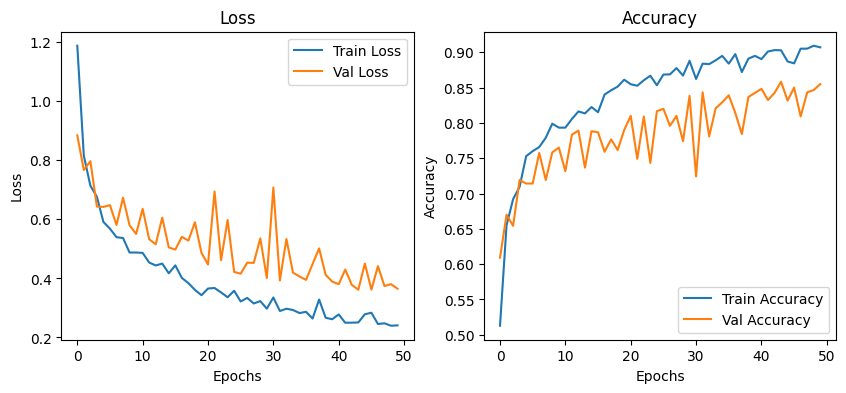

Number of images per class in test data before balancing:
{0: 179, 1: 12, 2: 640, 3: 448}
Number of images per class in test data after balancing:
{0: 320, 1: 320, 2: 320, 3: 319}
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 756ms/step - accuracy: 0.8747 - loss: 0.3475
Test Accuracy: 0.84
Test Loss: 0.39
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 736ms/step
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.81      0.74      0.78       320
ModerateDemented       0.90      0.90      0.90       320
     NonDemented       0.66      0.81      0.73       320
VeryMildDemented       0.71      0.61      0.66       319

        accuracy                           0.77      1279
       macro avg       0.77      0.77      0.76      1279
    weighted avg       0.77      0.77      0.76      1279

Confusion Matrix:
[[238  32  26  24]
 [  0 288  29   3]
 [  8   0 258  54]
 [ 47   0  77 195]]


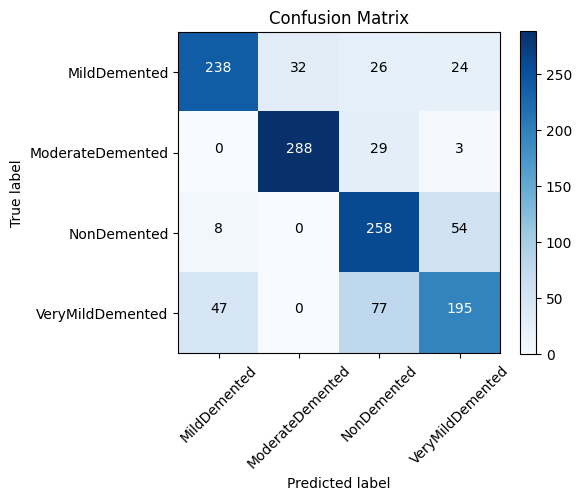

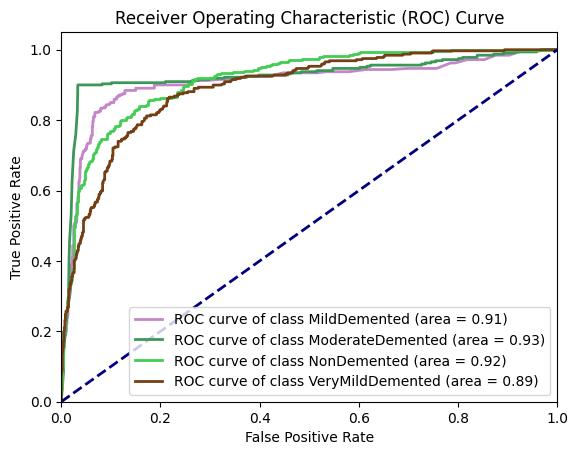

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import itertools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Assuming `classes` is a dictionary where keys are class labels and values are class names
num_classes = len(classes)

# Plot loss and accuracy
plt.figure(figsize=(10, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Test dataset processing and evaluation
test_path = 'Dataset/test/'
X_test, Y_test = load_images(test_path)

unique, counts = np.unique(Y_test, return_counts=True)
print("Number of images per class in test data before balancing:")
print(dict(zip(unique, counts)))

Y_test = Y_test.astype(int)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define oversampling and undersampling strategies for test data
oversampler = RandomOverSampler(sampling_strategy={0: 320, 1: 320})
undersampler = RandomUnderSampler(sampling_strategy={2: 320, 3: 319})

# Apply oversampling
X_test_oversampled, Y_test_oversampled = oversampler.fit_resample(X_test_flat, Y_test)

# Apply undersampling
X_test_resampled, Y_test_resampled = undersampler.fit_resample(X_test_oversampled, Y_test_oversampled)

# Reshape X_test_resampled back to (n_samples, 224, 224, 3)
num_samples = X_test_resampled.shape[0]
X_test_resampled = X_test_resampled.reshape(num_samples, 224, 224, 3)

# Print class distributions after balancing
unique, counts = np.unique(Y_test_resampled, return_counts=True)
print("Number of images per class in test data after balancing:")
print(dict(zip(unique, counts)))

X_test_resampled = preprocess_data(X_test_resampled)

# Test data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test_resampled, Y_test_resampled, batch_size=32, shuffle=False)

test_dataset = tf.data.Dataset.from_generator(lambda: test_generator,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, 224, 224, 3], [None]))
test_dataset = test_dataset.repeat()

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_dataset, steps=len(test_generator), verbose=1)
print(f'Test Accuracy: {accuracy:.2f}')
print(f'Test Loss: {loss:.2f}')

# Predict on the test dataset
Y_pred = model.predict(test_dataset, steps=len(test_generator), verbose=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# One-hot encode the test labels
Y_test_one_hot = to_categorical(Y_test_resampled, num_classes=num_classes)

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(Y_test_resampled, Y_pred_classes, target_names=list(classes.keys())))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(Y_test_resampled, Y_pred_classes)
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes.keys(), rotation=45)
plt.yticks(tick_marks, classes.keys())

# Annotate each cell with the corresponding value
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_one_hot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_one_hot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=np.random.rand(3,), lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(list(classes.keys())[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()